In [1]:
import torch
from torch import nn, optim
import torchvision
from torchvision import transforms, datasets, models, utils
from torch.utils.data import Dataset, DataLoader 
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from skimage import io, transform
from torch.optim import lr_scheduler
from skimage.transform import AffineTransform, warp
from sklearn.metrics import roc_auc_score, mean_absolute_error

import pandas as pd
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
# from efficientnet_pytorch import EfficientNet

INPUT_PATH = Path('../input')
OUTPUT_PATH = Path('../output')
TRAIN_PATH = INPUT_PATH / 'idao_dataset' / 'train'
PRIVATE_PATH = INPUT_PATH / 'idao_dataset' / 'private_test'
PUBLIC_PATH = INPUT_PATH / 'idao_dataset' / 'public_test'

RANDOM_SEED = 4444
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(RANDOM_SEED)

## Data prep

In [2]:
mapper1 = {
    1:[1, 0, 0, 0, 0, 0],
    3:[0, 1, 0, 0, 0, 0],
    6:[0, 0, 1, 0, 0, 0],
    10:[0, 0, 0, 1, 0, 0],
    20:[0, 0, 0, 0, 1, 0],
    30:[0, 0, 0, 0, 0, 1],
}

mapper2 = {
    1:0,
    3:1,
    6:2,
    10:3,
    20:4,
    30:5,
}

reverse_mapping = {
    0: 1,
    1: 3,
    2: 6,
    3: 10,
    4: 20,
    5: 30
}

In [3]:
import glob
images = glob.glob(str(TRAIN_PATH / '**/*.png'), recursive=True)

train_images, test_images = train_test_split(images, shuffle = True, random_state = RANDOM_SEED)

In [4]:
def calc_metric(y_binary_true, y_binary_pred, y_reg_true, y_reg_pred):
    '''
    Competition metric
    '''
    
    roc = roc_auc_score(y_binary_true, y_binary_pred)
    mae = mean_absolute_error(y_reg_true, y_reg_pred)
    return 1000 * (roc - mae), roc, mae

In [31]:
class DataGetter(Dataset):
    def __init__(self, image_paths, train=True, transform=None):
 
        self.image_paths = image_paths 
        self.transform=transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image=cv2.imread(self.image_paths[idx])
        if len(self.image_paths[idx].split('_')) == 18:
            particle_class = 0 # ER
            particle_energy = int(self.image_paths[idx].split('_')[7])
        else:
            particle_class = 1 # HE
            particle_energy = int(self.image_paths[idx].split('_')[8])
        
        sample={
            'image': np.uint8(image), 
            'particle_class': particle_class,
            'particle_energy': particle_energy
            }

        #Applying transformation
        if self.transform:
            sample['image']=self.transform(sample['image'])
            
        return sample

In [32]:
augs = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([128,128]),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), 
    ])

In [33]:
transformed_train_data = DataGetter(train_images, train=True, transform=augs)
transformed_test_data = DataGetter(test_images, train=False, transform=augs)

train_dataloader = DataLoader(transformed_train_data, batch_size=32, shuffle=True) #, num_workers=2
test_dataloader = DataLoader(transformed_test_data, batch_size=32, shuffle=True)

## Training classification

In [9]:
import torchvision.models as models

class CNNClassification(nn.Module):
    def __init__(self, pretrained=False):
        super(CNNClassification, self).__init__()
        if pretrained:
            self.model = models.resnet18(pretrained=True)
        else:
            self.model = models.resnet18()
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        
        self.fc0 = nn.Linear(512, 64)
        self.fc1 = nn.Linear(64, 2)  # For classification
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.relu(self.fc0(x))
        particle_class = torch.softmax(self.fc1(x), dim = 1)
        return {'particle_class': particle_class}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_cl = CNNClassification(False).to(device)

In [10]:
# for item in train_dataloader:
#     img = item['image']
#     break
# model_CNN(img.to(device))

In [11]:
#For binary output:particle_class
criterion_binary= nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cl.parameters(), lr=1e-3)

In [13]:
def train_model(model, criterion_binary, optimizer, n_epochs=5):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    for epoch in range(1, n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        comp_metric = 0 
        comp_val_metric = 0
        batches = 0
        val_batches = 0
        max_batches = 256
        # train the model #
        model.train()
        for batch_idx, sample_batched in enumerate(train_dataloader):
            if batches > max_batches:
                break
            # importing data and moving to GPU
            image, particle_class = sample_batched['image'].to(device),\
                                             sample_batched['particle_class'].to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            output = model(image)
            label_class = output['particle_class']
    
            
            particle_class = particle_class.squeeze().type(torch.LongTensor).to(device)
            
            
            y_pred_binary = label_class.cpu().detach().numpy()[:, 1]
            y_true_binary = particle_class.cpu().detach().numpy()
            
            roc = roc_auc_score(y_true_binary, y_pred_binary) 

            loss_binary = criterion_binary(label_class, particle_class)
            
            torch.cuda.empty_cache()
            loss = loss_binary
            # back prop
            loss.backward()
            # grad
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 50 == 0:
                print('Epoch %d, Batch %d loss: %.6f ROC AUC %.6f' %
                  (epoch, batch_idx + 1, train_loss, roc))
            batches += 1
        # validate the model #
        model.eval()
        
        y_preds = []
        y_trues = []
        for batch_idx, sample_batched in enumerate(test_dataloader):
            if val_batches > max_batches:
                break
            image, particle_class = sample_batched['image'].to(device),\
                                             sample_batched['particle_class'].to(device)
                                              
            
            output = model(image)

            label_class = output['particle_class']

            
            particle_class = particle_class.squeeze().type(torch.LongTensor).to(device)
            
            
            y_pred_binary = label_class.cpu().detach().numpy()[:, 1]
            y_true_binary = particle_class.cpu().detach().numpy()
            
            y_preds.extend(list(y_pred_binary))
            y_trues.extend(list(y_true_binary))
            
            # calculate loss
            loss_binary = criterion_binary(label_class, particle_class)
            
            loss = loss_binary
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            val_batches += 1
        
        roc_val = roc_auc_score(y_trues, y_preds) 
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \t ROC AUC {:.6f}'.format(
            epoch, train_loss, valid_loss, roc_val))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model, OUTPUT_PATH / 'model_classification.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
    # return trained model
    return model

In [14]:
model_cl = train_model(model_cl, criterion_binary, optimizer)

Epoch 1, Batch 1 loss: 0.694436 ROC AUC 0.517647
Epoch 1, Batch 51 loss: 0.419119 ROC AUC 1.000000
Epoch 1, Batch 101 loss: 0.383787 ROC AUC 1.000000
Epoch 1, Batch 151 loss: 0.365572 ROC AUC 1.000000
Epoch 1, Batch 201 loss: 0.353748 ROC AUC 1.000000
Epoch 1, Batch 251 loss: 0.348886 ROC AUC 1.000000
Epoch: 1 	Training Loss: 0.348269 	Validation Loss: 0.814128 	 ROC AUC 0.985322
Validation loss decreased (inf --> 0.814128).  Saving model ...
Epoch 2, Batch 1 loss: 0.313323 ROC AUC 1.000000
Epoch 2, Batch 51 loss: 0.320365 ROC AUC 1.000000
Epoch 2, Batch 101 loss: 0.320129 ROC AUC 1.000000
Epoch 2, Batch 151 loss: 0.327909 ROC AUC 1.000000
Epoch 2, Batch 201 loss: 0.326355 ROC AUC 1.000000
Epoch 2, Batch 251 loss: 0.324331 ROC AUC 1.000000
Epoch: 2 	Training Loss: 0.324073 	Validation Loss: 0.314672 	 ROC AUC 0.999992
Validation loss decreased (0.814128 --> 0.314672).  Saving model ...
Epoch 3, Batch 1 loss: 0.313262 ROC AUC 1.000000
Epoch 3, Batch 51 loss: 0.364007 ROC AUC 0.874494
Ep

## Training regression

In [34]:
import torchvision.models as models

class CNNReg(nn.Module):
    def __init__(self, pretrained=False):
        super(CNNReg, self).__init__()
        if pretrained:
            self.model = models.resnet18(pretrained=True)
        else:
            self.model = models.resnet18()
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        
        self.fc0 = nn.Linear(512, 64)
        self.fc1 = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.relu(self.fc0(x))
        particle_energy = self.fc1(x)
        return {'particle_energy': particle_energy}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_reg = CNNReg(False).to(device)

In [35]:
criterion_reg= nn.L1Loss()
optimizer = optim.Adam(model_reg.parameters(), lr=1e-3)

In [36]:
for item in train_dataloader:
    img = item['image']
    break
model_reg(img.to(device))

{'particle_energy': tensor([[-0.0255],
         [-0.0664],
         [-0.0043],
         [-0.0309],
         [-0.0711],
         [-0.0333],
         [-0.1106],
         [-0.0597],
         [-0.0341],
         [-0.0332],
         [ 0.0095],
         [-0.0983],
         [-0.1056],
         [-0.0271],
         [-0.0753],
         [-0.0827],
         [-0.0562],
         [-0.0565],
         [-0.0620],
         [ 0.0111],
         [-0.0771],
         [-0.0611],
         [-0.0417],
         [-0.0589],
         [-0.0124],
         [-0.0313],
         [-0.1279],
         [-0.0512],
         [-0.0298],
         [-0.0297],
         [-0.0540],
         [-0.0438]], device='cuda:0', grad_fn=<AddmmBackward>)}

In [37]:
def train_model_reg(model, criterion_reg, optimizer, n_epochs=5):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    for epoch in range(1, n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        comp_metric = 0 
        comp_val_metric = 0
        batches = 0
        val_batches = 0
        max_batches = 256
        # train the model #
        model.train()
        y_preds = []
        y_trues = []
        for batch_idx, sample_batched in enumerate(train_dataloader):
            if batches > max_batches:
                break
            # importing data and moving to GPU
            image, particle_energy = sample_batched['image'].to(device),\
                                             sample_batched['particle_energy'].to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            output = model(image)
            label_energy = output['particle_energy']
    
            
            particle_energy = particle_energy.squeeze().type(torch.FloatTensor).to(device)
            
            
            y_pred_reg = label_energy.cpu().detach().numpy()
            #y_pred_reg = [reverse_mapping[x] for x in list(np.argmax(y_pred_reg, axis = 1))]
            
            y_true_reg = particle_energy.cpu().detach().numpy()
            #y_true_reg = [reverse_mapping[x] for x in list(y_true_reg)]
            
            
            mae = mean_absolute_error(y_true_reg, y_pred_reg) 

            loss_reg = criterion_reg(label_energy.reshape(-1), particle_energy)
            
            y_preds.extend(list(y_pred_reg))
            y_trues.extend(list(y_true_reg))
            
            
            torch.cuda.empty_cache()
            loss = loss_reg
            # back prop
            loss.backward()
            # grad
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 50 == 0:
                print('Epoch %d, Batch %d loss: %.6f MAE %.6f' %
                  (epoch, batch_idx + 1, train_loss, mae))
            batches += 1
        # validate the model #
        model.eval()
        
        y_preds = []
        y_trues = []
        for batch_idx, sample_batched in enumerate(test_dataloader):
            if val_batches > max_batches:
                break
            # importing data and moving to GPU
            image, particle_energy = sample_batched['image'].to(device),\
                                             sample_batched['particle_energy'].to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            output = model(image)
            label_energy = output['particle_energy']

            
            particle_energy = particle_energy.squeeze().type(torch.FloatTensor).to(device)
            
            
            y_pred_reg = label_energy.cpu().detach().numpy()
            #y_pred_reg = [reverse_mapping[x] for x in list(np.argmax(y_pred_reg, axis = 1))]
            
            y_true_reg = particle_energy.cpu().detach().numpy()
            #y_true_reg = [reverse_mapping[x] for x in list(y_true_reg)]
            
            y_preds.extend(list(y_pred_reg))
            y_trues.extend(list(y_true_reg))
            

            loss_reg = criterion_reg(label_energy.reshape(-1), particle_energy)
            
            loss = loss_reg
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            val_batches += 1
        
        mae_val = mean_absolute_error(y_trues, y_preds) 
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \t MAE {:.6f}'.format(
            epoch, train_loss, valid_loss, mae_val))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model, OUTPUT_PATH / 'model_regression.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
    # return trained model
    return model

In [38]:
model_reg = train_model_reg(model_reg, criterion_reg, optimizer)

Epoch 1, Batch 1 loss: 11.881562 MAE 11.881563
Epoch 1, Batch 51 loss: 3.785183 MAE 2.001868
Epoch 1, Batch 101 loss: 2.845062 MAE 1.975827
Epoch 1, Batch 151 loss: 2.477610 MAE 2.870064
Epoch 1, Batch 201 loss: 2.270208 MAE 0.798639
Epoch 1, Batch 251 loss: 2.126450 MAE 2.523784
Epoch: 1 	Training Loss: 2.107121 	Validation Loss: 1.767886 	 MAE 1.767579
Validation loss decreased (inf --> 1.767886).  Saving model ...
Epoch 2, Batch 1 loss: 1.127111 MAE 1.127111
Epoch 2, Batch 51 loss: 1.440896 MAE 1.172764
Epoch 2, Batch 101 loss: 1.409017 MAE 1.086116
Epoch 2, Batch 151 loss: 1.404670 MAE 0.848296
Epoch 2, Batch 201 loss: 1.353096 MAE 0.720378
Epoch 2, Batch 251 loss: 1.304661 MAE 2.185793
Epoch: 2 	Training Loss: 1.302291 	Validation Loss: 2.223934 	 MAE 2.225653
Epoch 3, Batch 1 loss: 1.096357 MAE 1.096357
Epoch 3, Batch 51 loss: 0.961057 MAE 0.516300
Epoch 3, Batch 101 loss: 1.091048 MAE 2.216814
Epoch 3, Batch 151 loss: 1.018790 MAE 0.817638
Epoch 3, Batch 201 loss: 0.976668 MAE 0

## Sanity checks

In [39]:
model_cl = torch.load(OUTPUT_PATH / 'model_classification.pt')
model_cl.eval();

model_reg = torch.load(OUTPUT_PATH / 'model_regression.pt')
model_reg.eval();

In [40]:
class TestDataGetter(Dataset):
    def __init__(self, image_paths, train=True, transform=None):
 
        self.image_paths = image_paths 
        self.transform=transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image=cv2.imread(self.image_paths[idx])
        
        sample={
            'image': np.uint8(image)
            }

        #Applying transformation
        if self.transform:
            sample['image']=self.transform(sample['image'])
            
        return sample

In [41]:
private_test = glob.glob(str(PRIVATE_PATH / '**/*.png'), recursive=True)
public_test = glob.glob(str(PUBLIC_PATH / '**/*.png'), recursive=True)

In [42]:
private_test_getter = TestDataGetter(private_test, transform=augs)
public_test_getter = TestDataGetter(public_test, transform=augs)

private_test_dataloader = DataLoader(private_test_getter, batch_size=32, shuffle=False) #, num_workers=2
public_test_dataloader = DataLoader(public_test_getter, batch_size=32, shuffle=False)

In [43]:
# public set

public_predictions = []
for batch in public_test_dataloader:
    imgs = batch['image'].to(device)
    preds = model_cl(imgs)
    preds = preds['particle_class'].cpu().detach().numpy()
    preds = np.argmax(preds, axis = 1)
    
    public_predictions.extend(preds)
pd.Series(public_predictions).value_counts()

1    755
0    747
dtype: int64

In [44]:
# public set

public_predictions = []
for batch in public_test_dataloader:
    imgs = batch['image'].to(device)
    preds = model_reg(imgs)
    preds = preds['particle_energy'].cpu().detach().numpy().reshape(-1)
    
    public_predictions.extend(preds)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

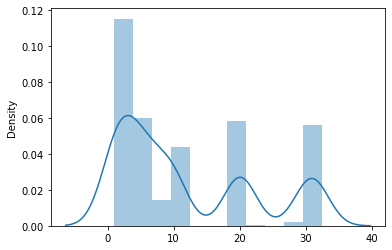

In [45]:
sns.distplot(public_predictions)

In [98]:
# private set

private_predictions = []
for batch in private_test_dataloader:
    imgs = batch['image'].to(device)
    preds = model(imgs)
    preds = preds['particle_class'].cpu().detach().numpy()
    preds = np.argmax(preds, axis = 1)
    
    private_predictions.extend(preds)
pd.Series(private_predictions).value_counts()

KeyboardInterrupt: 

## Predict for test

In [69]:
model_cl = torch.load(OUTPUT_PATH / 'model_classification.pt')
model_cl.eval();

model_reg = torch.load(OUTPUT_PATH / 'model_regression.pt')
model_reg.eval();

In [46]:
sample_submission = pd.read_csv(INPUT_PATH / 'track1_predictions_example.csv')

In [53]:
private_ids = [t.split('/')[-1].split('.')[0] for t in private_test]
public_ids = [t.split('/')[-1].split('.')[0] for t in public_test]

sample_submission['path'] = sample_submission['id'].apply(lambda x: PRIVATE_PATH / f'{x}.png' if x in private_ids else PUBLIC_PATH / f'{x}.png')

In [72]:
test_getter = TestDataGetter(sample_submission['path'].apply(str).values, transform=augs)
test_dataloader = DataLoader(test_getter, batch_size=32, shuffle=False) #, num_workers=2


predictions_class = []
predictions_energy = []
for batch in test_dataloader:
    imgs = batch['image'].to(device)
    preds_class = model_cl(imgs)
    preds_class = preds_class['particle_class'].cpu().detach().numpy()
    preds_class = np.argmax(preds_class, axis = 1)
    
    preds_energy = model_reg(imgs)
    preds_energy = preds_energy['particle_energy'].cpu().detach().numpy().reshape(-1)
    
    predictions_class.extend(preds_class)
    predictions_energy.extend(preds_energy)

In [208]:
sample_submission['classification_predictions'] = predictions_class
sample_submission['regression_predictions'] = predictions_energy

sample_submission.drop(columns = ['path']).to_csv(OUTPUT_PATH / 'predictions.csv', index  = None)

## Postprocessing

In [209]:
PUBLIC_SET_BOUNDARY = 1502
prediction_indexes = {
    'public_test_er': [0, 750],
    'public_test_he': [750, PUBLIC_SET_BOUNDARY],
    'private_test_er': '?',
    'private_test_he': '?'
}

prediction_allowed_values = {
    'public_test_er': [3, 10, 30],
    'public_test_he': [1, 6, 20],
    'private_test_er':  [1, 6, 20],
    'private_test_he': [3, 10, 30]
}

In [214]:
def correctPredictions(x, allowedPreds = np.array([1,2,3])):
    preds = x.copy()
    for i in range(preds.shape[0]):
        preds[i] = allowedPreds[np.argmin(np.abs(preds[i] - allowedPreds))]
    
    return preds

part = 'public_test_er'
values = sample_submission.iloc[prediction_indexes[part][0] : prediction_indexes[part][1], 2].reset_index(drop = True)
sample_submission.iloc[prediction_indexes[part][0] : prediction_indexes[part][1], 2] = correctPredictions(values, prediction_allowed_values[part]).values

part = 'public_test_he'
values = sample_submission.iloc[prediction_indexes[part][0] : prediction_indexes[part][1], 2].reset_index(drop = True)
sample_submission.iloc[prediction_indexes[part][0] : prediction_indexes[part][1], 2] = correctPredictions(values, prediction_allowed_values[part]).values

In [204]:
sample_submission.drop(columns = ['path']).to_csv(OUTPUT_PATH / 'predictions_postprocessed.csv', index  = None)

In [150]:
sample_submission.iloc[PUBLIC_SET_BOUNDARY+7500:]['classification_predictions'].value_counts()

1    7550
0      12
Name: classification_predictions, dtype: int64

In [90]:
sample_submission.iloc[PUBLIC_SET_BOUNDARY:PUBLIC_SET_BOUNDARY + 7500-3]['classification_predictions'].value_counts()

0    5362
1    2135
Name: classification_predictions, dtype: int64

In [89]:
sample_submission.iloc[1500 + 7500-3:]['classification_predictions'].value_counts()

1    7555
0      12
Name: classification_predictions, dtype: int64

In [96]:
sample_submission['path'].apply(lambda x: str(x).split('/')[-2]).iloc[1502:].value_counts()

private_test    15062
Name: path, dtype: int64

In [129]:
allowedPreds = np.array([1,2,3])
allowedPreds[np.argmin(np.abs(10.8 - allowedPreds))]

3

In [142]:
sample_submission.iloc[PUV]

,id,classification_predictions,regression_predictions,path
750,d88edebbf8247af207f19294fd7d1514fd220431,1,1.023144,../input/idao_dataset/public_test/d88edebbf824...
751,a4c526a9038cf3bfb8a0ad85cf0e7b03f277eb0a,1,1.068277,../input/idao_dataset/public_test/a4c526a9038c...
752,0c4e389c867a634186b93e511a7d19d2591b668b,1,1.027634,../input/idao_dataset/public_test/0c4e389c867a...
753,c64d46234689a9616f3bb48389ca60eb0286f875,1,5.801307,../input/idao_dataset/public_test/c64d46234689...
754,d05e5557914fb378c851d4e64687a008b11d0b94,1,19.992479,../input/idao_dataset/public_test/d05e5557914f...
...,...,...,...,...
1499,0851c743440bb0bafa222e4bbedfaf2f66ac7209,1,5.794290,../input/idao_dataset/public_test/0851c743440b...
1500,7b2edfb684bcfdcf34d546cd9a4563a65ef8e7d4,1,5.753428,../input/idao_dataset/public_test/7b2edfb684bc...
1501,7b0074823b3301443ddfafe179ed44a412364c32,1,19.779394,../input/idao_dataset/public_test/7b0074823b33...
1502,8dbaee16550363fe6f4e7f32ed6c8419926354ee,0,23.464390,../input/idao_dataset/private_test/8dbaee16550...


In [137]:
def correctPredictions(x, allowedPreds = np.array([1,2,3])):
    preds = x.copy()
    for i in range(preds.shape[0]):
        preds[i] = allowedPreds[np.argmin(np.abs(preds[i] - allowedPreds))]
    
    return preds
correctPredictions(sample_submission.iloc[:750, 2])

0      3.0
1      3.0
2      3.0
3      3.0
4      3.0
      ... 
745    3.0
746    3.0
747    3.0
748    3.0
749    3.0
Name: regression_predictions, Length: 750, dtype: float64

In [138]:
sample_submission.iloc[:750]

,id,classification_predictions,regression_predictions,path
0,9a8b8bfc7a06afd346ff1c88f1f7a03316a9bc76,0,2.782609,../input/idao_dataset/public_test/9a8b8bfc7a06...
1,2caa5748f814bbdbc64f4db43d7412ce359a777b,0,9.784853,../input/idao_dataset/public_test/2caa5748f814...
2,b879970a23fc2a3b093bce85096808f13eaa69fb,0,9.664519,../input/idao_dataset/public_test/b879970a23fc...
3,a4d3cb5abbdc11518bb67ae7f2c415de808effb3,0,9.832215,../input/idao_dataset/public_test/a4d3cb5abbdc...
4,df8de9207196305057f73cea03d265ba720cb6e1,0,30.029110,../input/idao_dataset/public_test/df8de9207196...
...,...,...,...,...
745,f8bdabef01fcd90a653a4fd72fd75d02db9f557f,0,9.612540,../input/idao_dataset/public_test/f8bdabef01fc...
746,c292dc18588b7981b4cf7feec25ac86207332a56,0,2.809313,../input/idao_dataset/public_test/c292dc18588b...
747,2786388c5b2e0c3ea3e3417803b39c7919210fe4,0,30.932081,../input/idao_dataset/public_test/2786388c5b2e...
748,74e6412eb02ffd302abe71b5407f893415bb8a3a,0,9.593667,../input/idao_dataset/public_test/74e6412eb02f...


In [98]:
7491 + 7567

15058

In [101]:
2499 + 2501 + 2484

7484

In [102]:
2463 + 2503 + 2458

7424

In [103]:
7484 + 7424

14908

In [104]:
sample_submission.shape

(16564, 4)

In [105]:
14908 + 1500

16408